# Pet Finder - Adopción de Mascotas

PetFinder.es una plataforma de adopción de Mascotas de Malasia, con una base de datos de más de 150.000 animales. 

Las tasas de adopción de animales están fuertemente correlacionadas con los metadatos asociados con sus perfiles en línea, como el texto descriptivo y las características de las fotografías. Como ejemplo, PetFinder está experimentando actualmente con una herramienta de inteligencia artificial simple llamada Cuteness Meter, que clasifica qué tan linda es una mascota en función de las cualidades presentes en sus fotos.

En esta competencia, desarrollará algoritmos para predecir la adoptabilidad de las mascotas, específicamente, ¿qué tan rápido se adopta una mascota?

Web Organización: https://www.petfinder.my/

Datos: https://www.kaggle.com/c/petfinder-adoption-prediction



## Script Inicial - Análisis Exploratorio

En este trabajo se busca predecir la velocidad a la que se adopta una mascota, según la lista de la mascota en PetFinder. 

A veces, un perfil representa a un grupo de mascotas. En este caso, la velocidad de adopción está determinada por la velocidad a la que se adoptan todas las mascotas. 

Los datos incluyen datos de **Texto Libre**, **Datos Tabulares** e **Emágenes**, lo que lo hace un dataset sumamente rico para explorar

### Ejemplos de Scripts de EDA (Exploratory Data Analysis)

* En R: https://www.kaggle.com/jaseziv83/an-extensive-eda-of-petfinder-my-data
* En Python: https://www.kaggle.com/artgor/exploration-of-data-step-by-step

File descriptions:

* train.csv - Tabular/text data for the training set
* test.csv - Tabular/text data for the test set
* sample_submission.csv - A sample submission file in the correct format
* breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
* color_labels.csv - Contains ColorName for each ColorID
* state_labels.csv - Contains StateName for each StateID

In [1]:
# Importación de Librerías
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud

%matplotlib inline
pd.set_option('display.max_columns', 30)
plt.rcParams['figure.figsize'] = [12.0, 8.0]

In [2]:
# Datos Tabulares
train = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')

In [7]:
train.shape

(14993, 24)

In [8]:
train.head() 

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


### Data Fields

* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

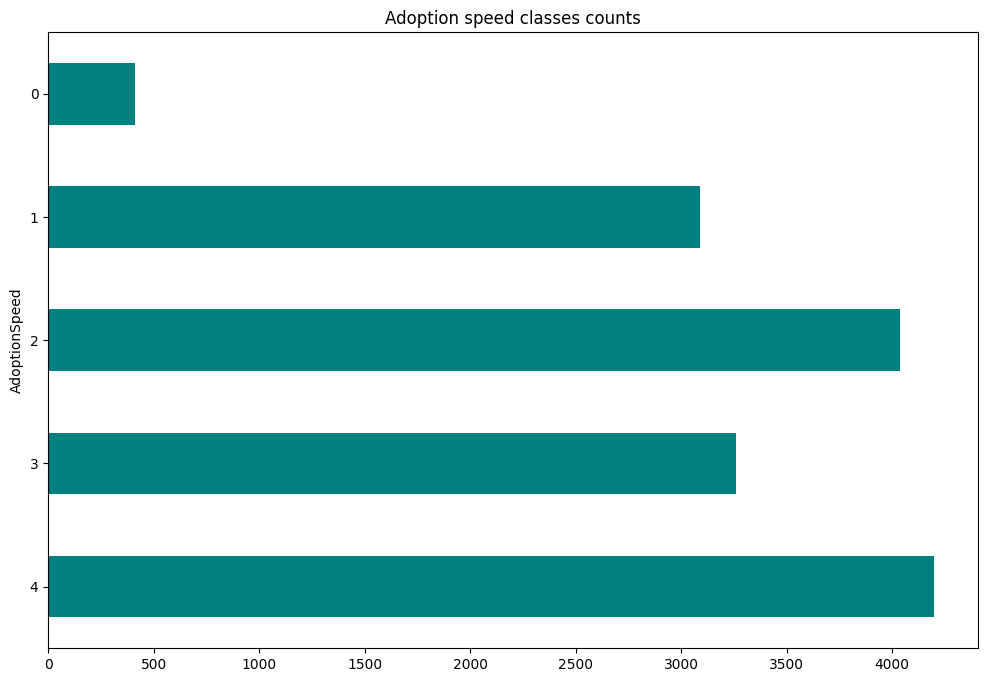

In [9]:
train['AdoptionSpeed'].value_counts().sort_index(ascending = False).plot(kind='barh', color='teal');
plt.title('Adoption speed classes counts');

### Target: AdoptionSpeed

The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [10]:
# Mapeamos el Tipo de Mascota
train['Type'] = train['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

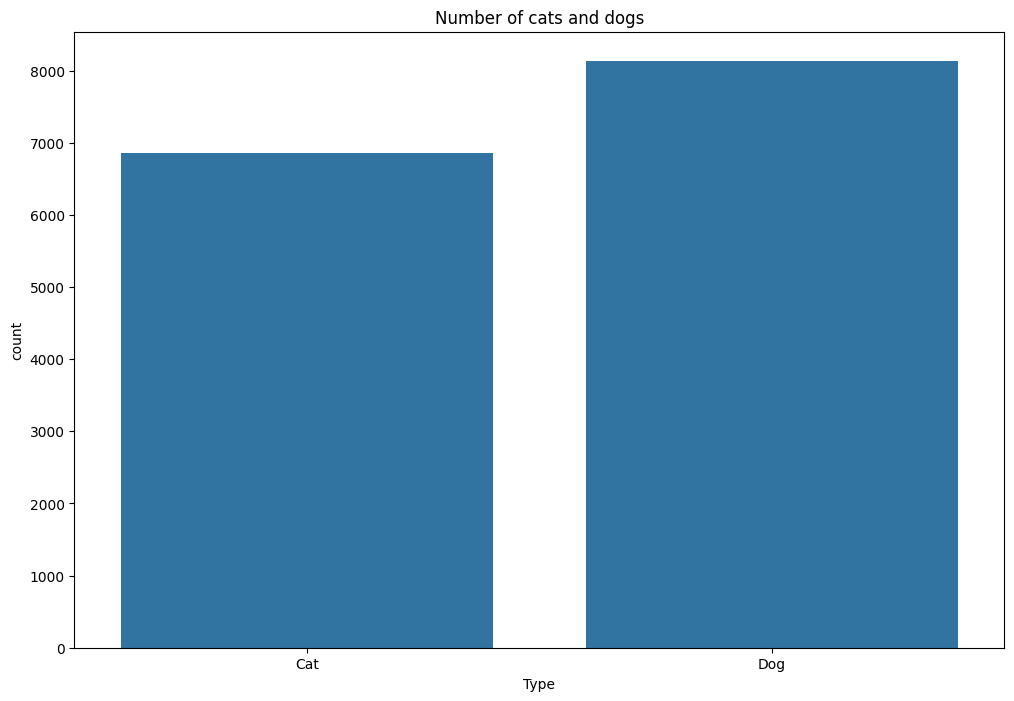

In [11]:
sns.countplot(x='Type', data=train);
plt.title('Number of cats and dogs');

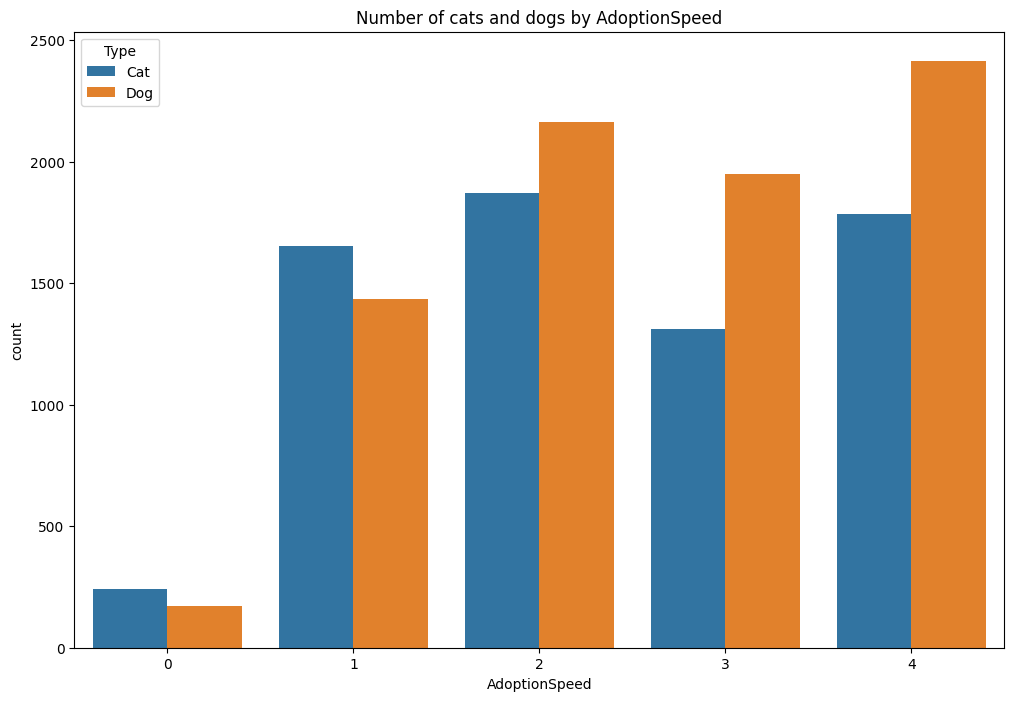

In [12]:
sns.countplot(x='AdoptionSpeed', data=train, hue='Type');
plt.title('Number of cats and dogs by AdoptionSpeed');

In [13]:
train.Name.value_counts()

Name
Baby                           66
Lucky                          64
Brownie                        54
No Name                        54
Mimi                           52
                               ..
Snow-White                      1
Estelle                         1
Lily & Rose                     1
4 Little Kittens & Cat Mama     1
4 PUPPIES FOR ADOPTION          1
Name: count, Length: 9059, dtype: int64

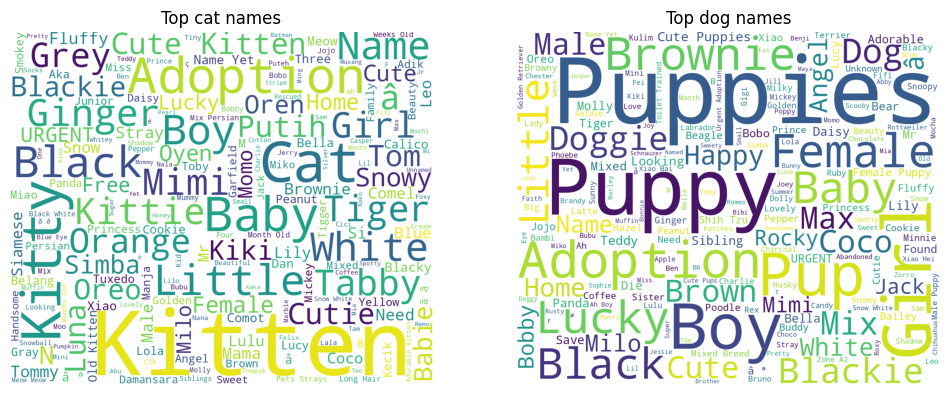

In [14]:
plt.subplot(1, 2, 1)
text_cat = ' '.join(train.loc[train['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(train.loc[train['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()

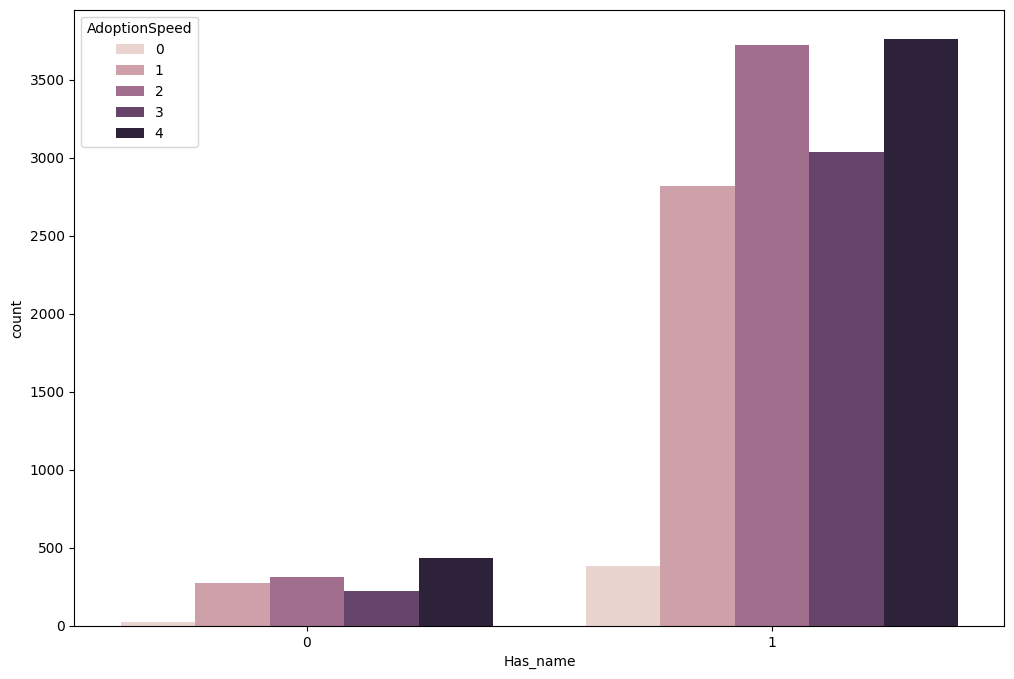

In [15]:
train['Name'] = train['Name'].fillna('Unnamed')
train['Has_name'] = 1
train.loc[train['Name'] == 'Unnamed', 'Has_name'] = 0

sns.countplot(x='Has_name', data=train, hue='AdoptionSpeed');

Text(0.5, 1.0, 'Distribution of pets age in Months')

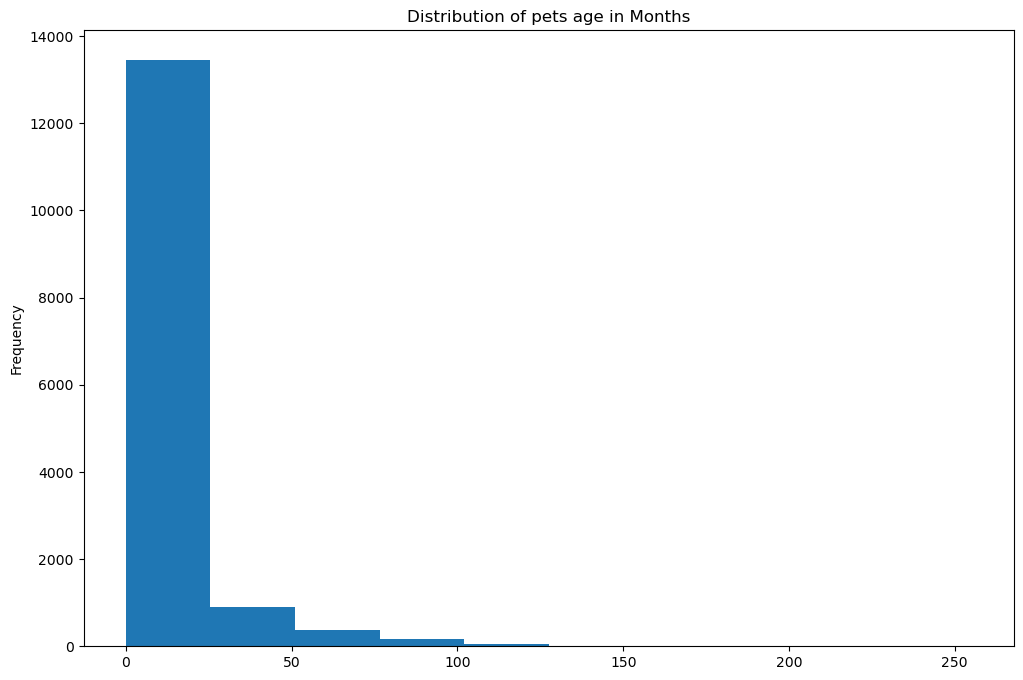

In [12]:
train['Age'].plot(kind='hist')
plt.title('Distribution of pets age in Months')

# Nulos

In [4]:
# Check the amount of null values
train.isnull().sum()


Type                0
Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

Solo 'Description tiene nulos'

# Variables categoricas

PetID - categorical - ID --> Should be dropped

AdoptionSpeed - categorical - target variable

Type - categorical - 1 = Cat, 2 = Dog

Name - categorical - Name of pet

Breed1 - categorical - see BreedLabels dictionary

Breed2 - categorical - see BreedLabels dictionary

Gender - categorical 1 =male, 2 = female, 3 = mixed (used for groups)

Color1 - categorical - see ColorLabels dictionary)

Color2 - categorical - see ColorLabels dictionary)

Color3 - categorical - see ColorLabels dictionary)

MaturitySize - categorical - 1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified

FurLength - categorical - 1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

Vaccinated - categorical - 1= Yes, 2 = No, 3 = Not Sure)

Dewormed - categorical - 1 = Yes, 2 = No, 3 = Not Sure)

Sterilized - categorical - 1 = Yes, 2 = No, 3 = Not Sure)

Health - categorical - 1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

State - categorical - see StateLabels dictionary)

RescuerID - categorical - ID

Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.




# Variables numericas

Age - Age of pet when listed, in months

Quantity - Number of pets represented in profile

Fee - Adoption fee (0 = Free)

VideoAmt - Total uploaded videos for this pet

PhotoAmt - Total uploaded photos for this pet

## Tareas a Realizar

#### Pre-procesamiento:

* Chequear Nulos y Decidir si Imputar o Descartar
* Chequear Variables Categóricas y convertirlas en Numéricas
* Estandarizar o Normalizar

#### Ideas para EDA:

* Analizar la Raza de las Mascotas
* Analizar el Género
* Analizar los 3 Colores Informados para cada Mascota
* Estudiar las variables de Salud: Vacunación, Esterilización, Desparacitación
* Entender el impacto del Fee cobrado
* Estudiar las Regiones Geográficas disponibles
* Analizar el impacto de tener Fotos y/o Videos

Todos estos análisis pueden hacerse en función de la Especie (Gato/Perro) y respecto al Target



# Images vs adoption speed

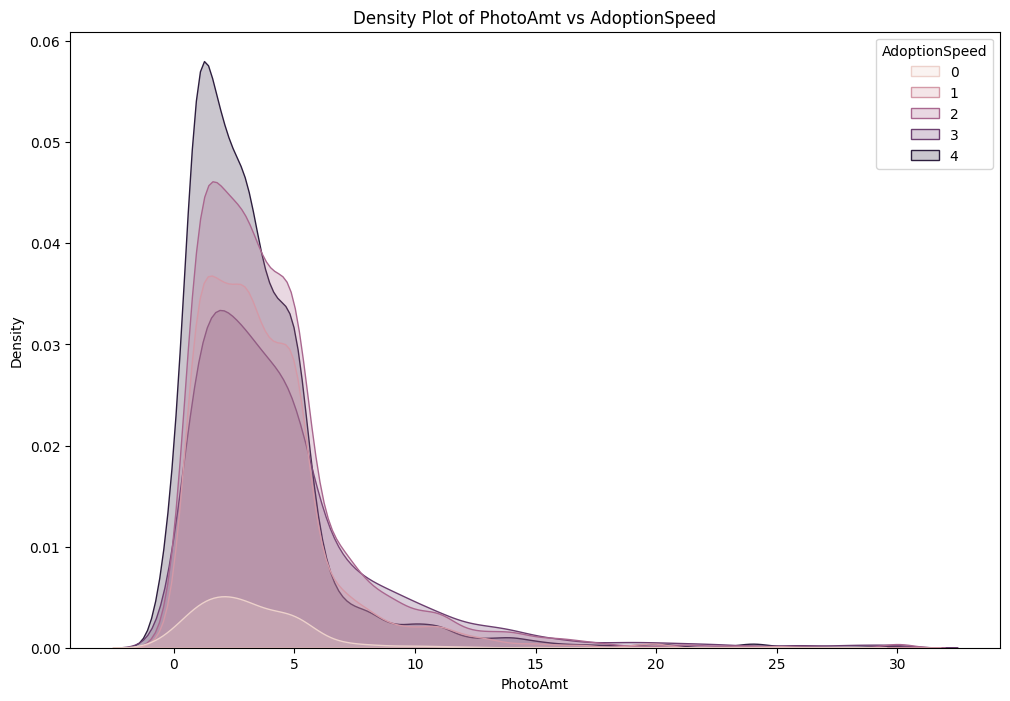

In [5]:
sns.kdeplot(data=train, x='PhotoAmt', hue='AdoptionSpeed', fill=True)
plt.title('Density Plot of PhotoAmt vs AdoptionSpeed')
plt.xlabel('PhotoAmt')
plt.ylabel('Density')
plt.show()

# Fee vs adoption speed

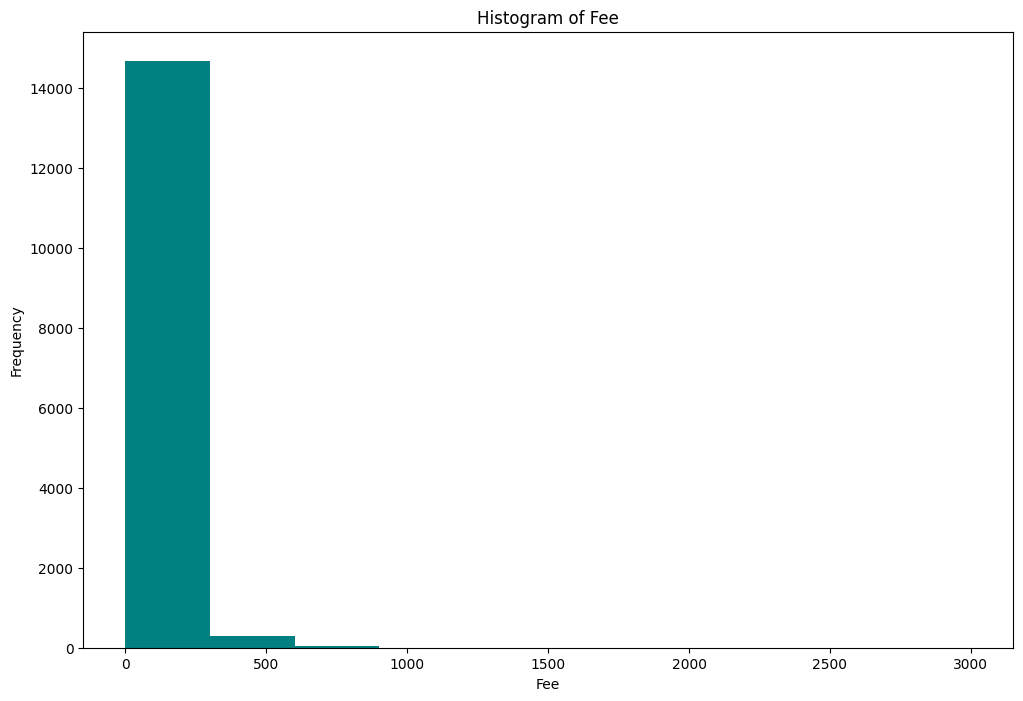

In [6]:
plt.hist(train['Fee'], bins=10, color='teal')
plt.title('Histogram of Fee')
plt.xlabel('Fee')
plt.ylabel('Frequency')
plt.show()

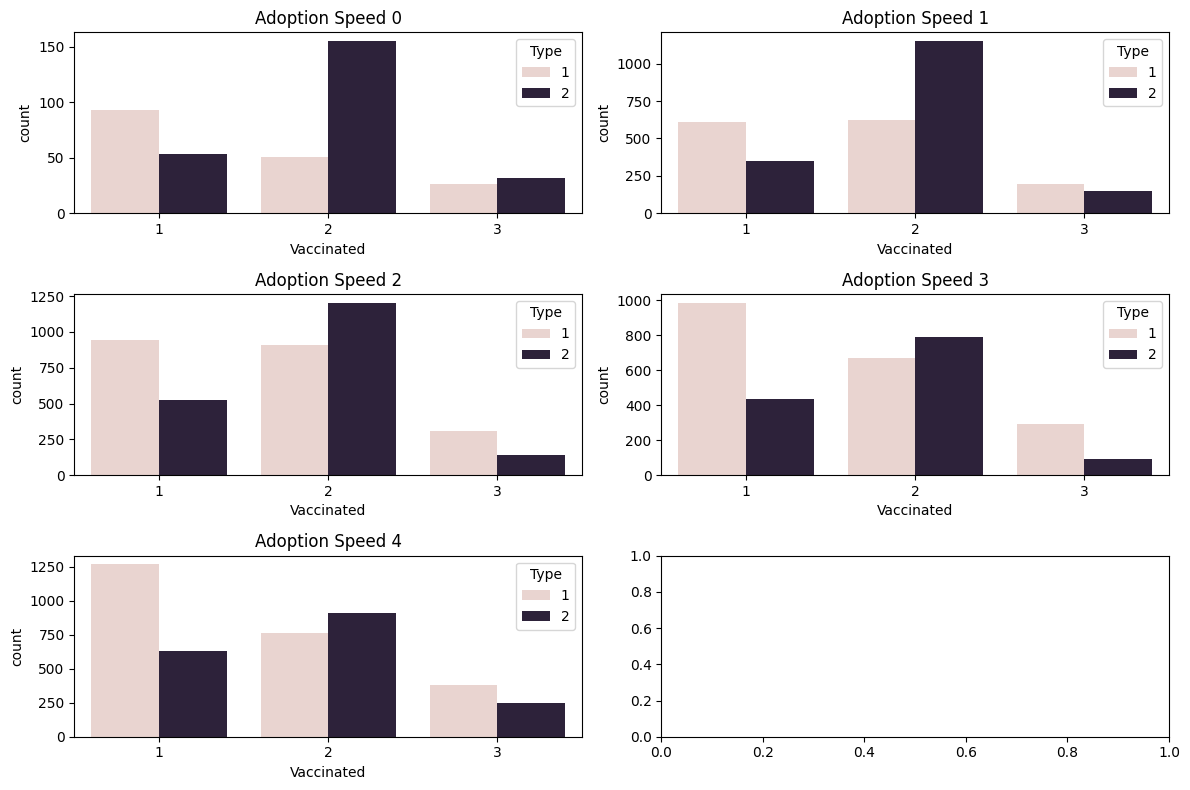

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Adoption Speed 0
sns.countplot(x='Vaccinated', data=train[train['AdoptionSpeed'] == 0], hue='Type', ax=axes[0, 0])
axes[0, 0].set_title('Adoption Speed 0')

# Adoption Speed 1
sns.countplot(x='Vaccinated', data=train[train['AdoptionSpeed'] == 1], hue='Type', ax=axes[0, 1])
axes[0, 1].set_title('Adoption Speed 1')

# Adoption Speed 2
sns.countplot(x='Vaccinated', data=train[train['AdoptionSpeed'] == 2], hue='Type', ax=axes[1, 0])
axes[1, 0].set_title('Adoption Speed 2')

# Adoption Speed 3
sns.countplot(x='Vaccinated', data=train[train['AdoptionSpeed'] == 3], hue='Type', ax=axes[1, 1])
axes[1, 1].set_title('Adoption Speed 3')

# Adoption Speed 4
sns.countplot(x='Vaccinated', data=train[train['AdoptionSpeed'] == 4], hue='Type', ax=axes[2, 0])
axes[2, 0].set_title('Adoption Speed 4')

plt.tight_layout()
plt.show()


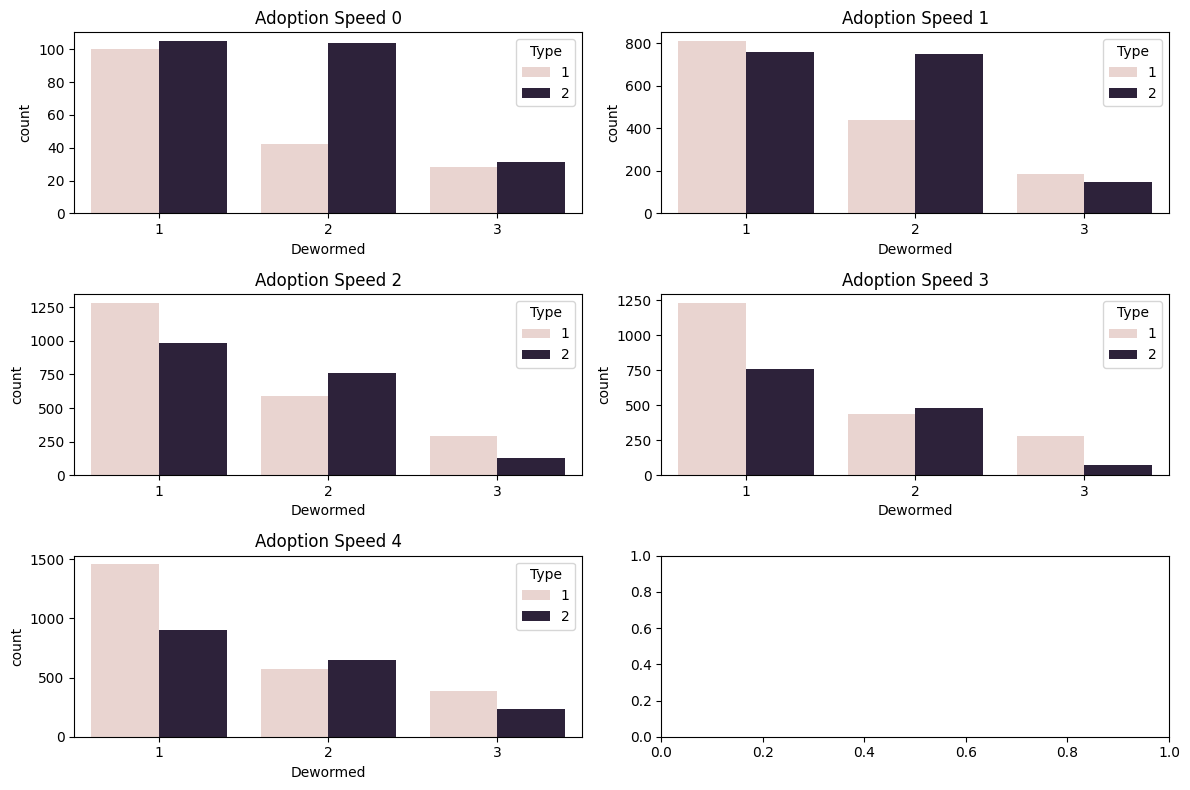

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Adoption Speed 0
sns.countplot(x='Dewormed', data=train[train['AdoptionSpeed'] == 0], hue='Type', ax=axes[0, 0])
axes[0, 0].set_title('Adoption Speed 0')

# Adoption Speed 1
sns.countplot(x='Dewormed', data=train[train['AdoptionSpeed'] == 1], hue='Type', ax=axes[0, 1])
axes[0, 1].set_title('Adoption Speed 1')

# Adoption Speed 2
sns.countplot(x='Dewormed', data=train[train['AdoptionSpeed'] == 2], hue='Type', ax=axes[1, 0])
axes[1, 0].set_title('Adoption Speed 2')

# Adoption Speed 3
sns.countplot(x='Dewormed', data=train[train['AdoptionSpeed'] == 3], hue='Type', ax=axes[1, 1])
axes[1, 1].set_title('Adoption Speed 3')

# Adoption Speed 4
sns.countplot(x='Dewormed', data=train[train['AdoptionSpeed'] == 4], hue='Type', ax=axes[2, 0])
axes[2, 0].set_title('Adoption Speed 4')

plt.tight_layout()
plt.show()

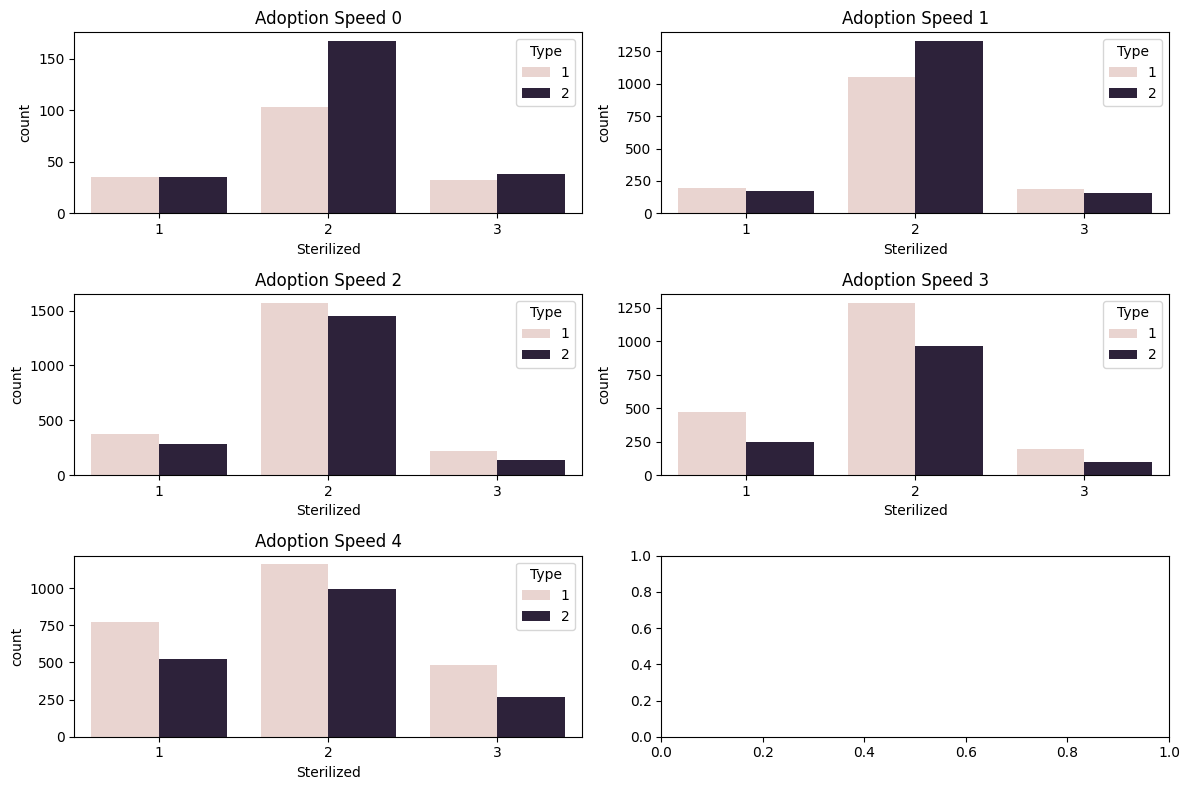

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Adoption Speed 0
sns.countplot(x='Sterilized', data=train[train['AdoptionSpeed'] == 0], hue='Type', ax=axes[0, 0])
axes[0, 0].set_title('Adoption Speed 0')

# Adoption Speed 1
sns.countplot(x='Sterilized', data=train[train['AdoptionSpeed'] == 1], hue='Type', ax=axes[0, 1])
axes[0, 1].set_title('Adoption Speed 1')

# Adoption Speed 2
sns.countplot(x='Sterilized', data=train[train['AdoptionSpeed'] == 2], hue='Type', ax=axes[1, 0])
axes[1, 0].set_title('Adoption Speed 2')

# Adoption Speed 3
sns.countplot(x='Sterilized', data=train[train['AdoptionSpeed'] == 3], hue='Type', ax=axes[1, 1])
axes[1, 1].set_title('Adoption Speed 3')

# Adoption Speed 4
sns.countplot(x='Sterilized', data=train[train['AdoptionSpeed'] == 4], hue='Type', ax=axes[2, 0])
axes[2, 0].set_title('Adoption Speed 4')

plt.tight_layout()
plt.show()

In [13]:
# Filter the dataframe for Type == 1
type_1_df = train[train['Type'] == 1]

# Group the dataframe by AdoptionSpeed and Breed1, and count the occurrences
grouped_df = type_1_df.groupby(['AdoptionSpeed', 'Breed1']).size().reset_index(name='Count')

# Sort the dataframe by AdoptionSpeed and Count in descending order
sorted_df = grouped_df.sort_values(['AdoptionSpeed', 'Count'], ascending=[True, False])

# Get the top 3 breeds for each AdoptionSpeed
top_3_breeds = sorted_df.groupby('AdoptionSpeed').head(3)
top_3_breeds

,AdoptionSpeed,Breed1,Count
28,0,307,81
17,0,179,16
10,0,109,10
97,1,307,859
88,1,205,66
79,1,179,51
168,2,307,1575
133,2,141,59
155,2,205,53
245,3,307,1381


In [18]:
top_3_breeds_unique = top_3_breeds['Breed1'].unique()
df_breeds = pd.read_csv('../input/petfinder-adoption-prediction/breed_labels.csv')
df_breeds[df_breeds['BreedID'].isin(top_3_breeds_unique)]

,BreedID,Type,BreedName
108,109,1,Golden Retriever
140,141,1,Labrador Retriever
178,179,1,Poodle
204,205,1,Shih Tzu
217,218,1,Terrier
240,307,1,Mixed Breed


In [28]:
# Filter the dataframe for Type == 1
type_2_df = train[train['Type'] == 2]

# Group the dataframe by AdoptionSpeed and Breed1, and count the occurrences
grouped_df2 = type_2_df.groupby(['AdoptionSpeed', 'Breed1']).size().reset_index(name='Count')

# Sort the dataframe by AdoptionSpeed and Count in descending order
sorted_df2 = grouped_df2.sort_values(['AdoptionSpeed', 'Count'], ascending=[True, False])

# Get the top 3 breeds for each AdoptionSpeed
top_3_breeds2 = sorted_df2.groupby('AdoptionSpeed').head(5)
top_3_breeds2

,AdoptionSpeed,Breed1,Count
10,0,266,92
9,0,265,45
13,0,285,20
16,0,292,18
8,0,264,17
37,1,266,780
36,1,265,334
35,1,264,99
55,1,292,87
59,1,299,82


In [19]:
top_3_breeds_unique2 = top_3_breeds2['Breed1'].unique()
df_breeds[df_breeds['BreedID'].isin(top_3_breeds_unique2)]

,BreedID,Type,BreedName
264,264,2,Domestic Long Hair
265,265,2,Domestic Medium Hair
266,266,2,Domestic Short Hair
285,285,2,Persian
299,299,2,Tabby
